In [1]:
from preamble import *
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['legend.numpoints'] = 1

# 整个机器学习流程大概是这个样子

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# The breast cancer dataset is a classic and very easy binary classification
# dataset.

# =================   ==============
# Classes                          2
# Samples per class    212(M),357(B)
# Samples total                  569
# Dimensionality                  30
# Features            real, positive
# =================   ==============

# 切分训练集和测试集
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 用scaler做特征预处理
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 应用SVM进行建模
svm.fit(X_train_scaled, y_train)
# 对test数据做预处理，并使用模型预测打分
X_test_scaled = scaler.transform(X_test)
svm.score(X_test_scaled, y_test)

0.972027972027972

### 回顾网格搜索

In [4]:
%%time
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("best cross-validation accuracy:", grid.best_score_)
print("test set score: ", grid.score(X_test_scaled, y_test))
print("best parameters: ", grid.best_params_)

best cross-validation accuracy: 0.9812311901504789
test set score:  0.972027972027972
best parameters:  {'C': 1, 'gamma': 1}
CPU times: user 1.34 s, sys: 542 µs, total: 1.34 s
Wall time: 1.34 s


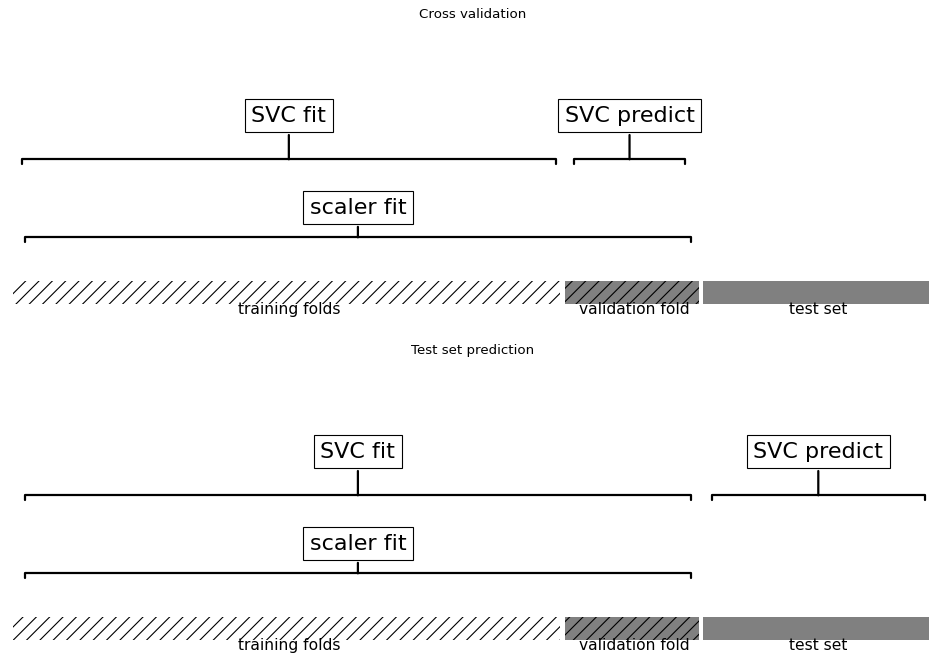

In [5]:
mglearn.plots.plot_improper_processing()

---

### 搭建流程/Pipeline！！


- 使用 `Pipeline` 类来创建一个包含数据预处理和模型训练两个步骤的机器学习流程。

In [6]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [8]:
pipe.score(X_test, y_test)

0.972027972027972

- Pipeline的优点是可以将多个步骤组合成一个整体，使得代码更加简洁，同时也可以防止数据泄露，因为它确保了数据预处理和模型训练始终在同一数据集上进行。
- 此外，Pipeline还可以与GridSearchCV等工具一起使用，进行超参数搜索。
- Pipeline通常在我们需要进行多个连续的步骤，例如数据预处理、特征选择、模型训练等，时使用。

### 串起来流程和网格搜索

In [9]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# 这里非常重要！一定要写明是名字为”svm“的超参数，中间的两个下划线是固定的写法

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("best cross-validation accuracy:", grid.best_score_)
print("test set score: ", grid.score(X_test, y_test))
print("best parameters: ", grid.best_params_)

best cross-validation accuracy: 0.9812311901504789
test set score:  0.972027972027972
best parameters:  {'svm__C': 1, 'svm__gamma': 1}


- 将Pipeline和GridSearchCV结合使用的优点是可以将数据预处理、模型训练和超参数搜索组合在一起，使得代码更加简洁，同时也可以防止数据泄露。
- 此外，这种方法还可以处理更复杂的情况，例如当我们需要对流程中的多个步骤进行超参数搜索时。

- 这种方法通常在我们需要同时进行数据预处理、模型训练和超参数搜索时使用，例如在比较不同的模型或者不同的超参数设置时。

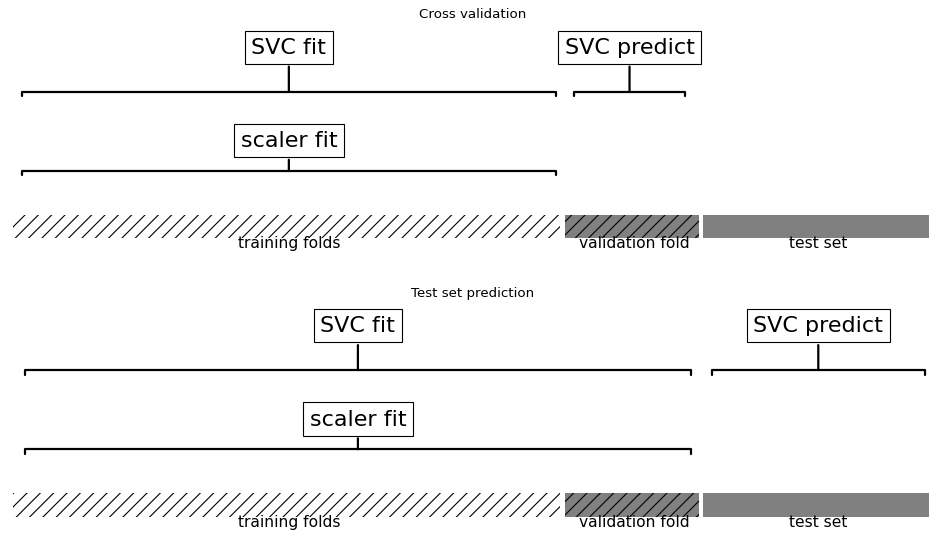

In [11]:
mglearn.plots.plot_proper_processing()

### 特征选择也可以加到 pipeline 中

特征选择是一种常见的数据预处理步骤，可以帮助我们减少数据的维度，提高模型的训练速度，同时也可能提高模型的性能。

In [12]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))  # 1w个特征！
y = rnd.normal(size=(100,))

In [15]:
from sklearn.feature_selection import SelectPercentile, f_regression

# 使用SelectPercentile类进行特征选择。这个类会选择与目标变量最相关的前5%的特征。
# 在这个例子中，我们使用了f_regression作为评分函数，它可以计算每个特征和目标变量的F值。
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print(X_selected.shape)

(100, 500)


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
# 使用Ridge类训练一个岭回归模型 （L2），并使用交叉验证评估其性能。

np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))

0.9057953065239822

In [18]:
# 使用Pipeline类创建一个包含特征选择和模型训练两个步骤的流程。

pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)), ("ridge", Ridge())])
np.mean(cross_val_score(pipe, X, y, cv=5))

-0.24655422384952824

- 将特征选择加入到流程中的优点是可以将数据预处理和模型训练组合在一起，使得代码更加简洁，同时也可以防止数据泄露。
- 此外，这种方法还可以处理更复杂的情况，例如当我们需要对流程中的多个步骤进行超参数搜索时。
- 这种方法通常在我们需要进行特征选择时使用，例如当数据的维度很高，或者我们希望减少模型的复杂度时。

### 使用更简单的函数 `make_pipeline`

- make_pipeline函数是Pipeline类的一个简化版本，它会自动根据每个步骤的类名生成步骤的名称。

In [19]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [20]:
# 使用steps属性查看流程的步骤。
# 这个属性返回一个列表，每个元素是一个元组，包含步骤的名称和对象。
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

#### 想要中间步骤的结果怎么办：取出来！

- 使用named_steps属性访问流程中的步骤。
- 这个属性返回一个字典，键是步骤的名称，值是步骤的对象。

In [22]:
# fit the pipeline defined above to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
# pca步骤的components_属性，这个属性包含了主成分分析的结果。
components = pipe.named_steps["pca"].components_
print(components.shape)

(2, 30)


#### 想要网格搜索的中间结果怎么办：取！

In [24]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [25]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

- 使用best_estimator_属性访问网格搜索的结果。
- 这个属性返回一个流程，这个流程使用了最优的超参数。
- 我们可以通过这个流程访问任何步骤的属性，例如在这个例子中，我们访问了logisticregression步骤的coef_属性，这个属性包含了逻辑回归模型的系数。

In [27]:
print(grid.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [28]:
print(grid.best_estimator_.named_steps["logisticregression"])

LogisticRegression(C=1, max_iter=1000)


In [29]:
print(grid.best_estimator_.named_steps["logisticregression"].coef_)

[[-0.436 -0.343 -0.408 -0.534 -0.15   0.61  -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.45  -0.13  -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.42 ]]


### 把各种预处理、参数调整、交叉验证放到一个流程里！

使用make_pipeline函数创建一个流程。这个流程包含三个步骤：
- 首先，使用StandardScaler进行数据预处理，将数据标准化；
- 然后，使用PolynomialFeatures生成多项式特征；
- 最后，使用Ridge（岭回归）进行模型训练。

In [31]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()) # L2

In [32]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

使用GridSearchCV类创建一个网格搜索对象。这个对象会在给定的超参数网格上进行搜索，找到最优的超参数。

In [33]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

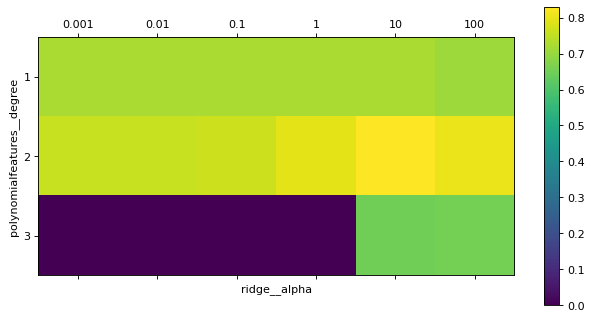

In [34]:
# 这个图显示了不同的超参数组合对应的交叉验证性能。
plt.matshow(np.array([s for s in grid.cv_results_['mean_test_score']]).reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])), param_grid['polynomialfeatures__degree'])

plt.colorbar()

In [35]:
print(grid.best_params_)

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [36]:
grid.score(X_test, y_test)

0.7683045464100124

In [37]:
# 对比一下不做多项式特征生成的结果
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.6272671927504456

- 将Pipeline和GridSearchCV结合使用的优点是可以将数据预处理、模型训练和超参数搜索组合在一起，使得代码更加简洁，同时也可以防止数据泄露。
- 此外，这种方法还可以处理更复杂的情况，例如当我们需要对流程中的多个步骤进行超参数搜索时。
- 这种方法通常在我们需要同时进行数据预处理、模型训练和超参数搜索时使用，例如在比较不同的模型或者不同的超参数设置时。